In [23]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(data.table)
library(circlize)
library(ComplexHeatmap)

# Real data analysis results

## Number of identified risk SNPs comparison

In [21]:
# load number data
num = fread('../real/reg9tis127-relative-number-comp-gwas30.csv', sep='\t', header=T)
n = nrow(num)
methods = c('AdaFDR2', 'AdaFDR1', 'LSMM', 'TGM')
methodlabel = setNames(c('PALM-Tree2', 'PALM-Tree1', 'LSMM', 'TGM'), methods)
methodlabel = factor(methodlabel, levels=methodlabel, labels=methodlabel)
thres = paste('FDR threshold =', c(0.05, 0.1))
long <- num %>%
  rename(Phenotype=V1) %>%
  pivot_longer(cols=-Phenotype, names_to='Method', values_to='Number') %>%
  arrange(Phenotype) %>%
  mutate(Number=ifelse(Number > 1, 1.1, Number)) %>%
  separate(Method, c('Method', 'facetlabel'), '_') %>%
  mutate(facetlabel=ifelse(facetlabel == 1, 0.05, 0.1),
         Method=methodlabel[Method]) 

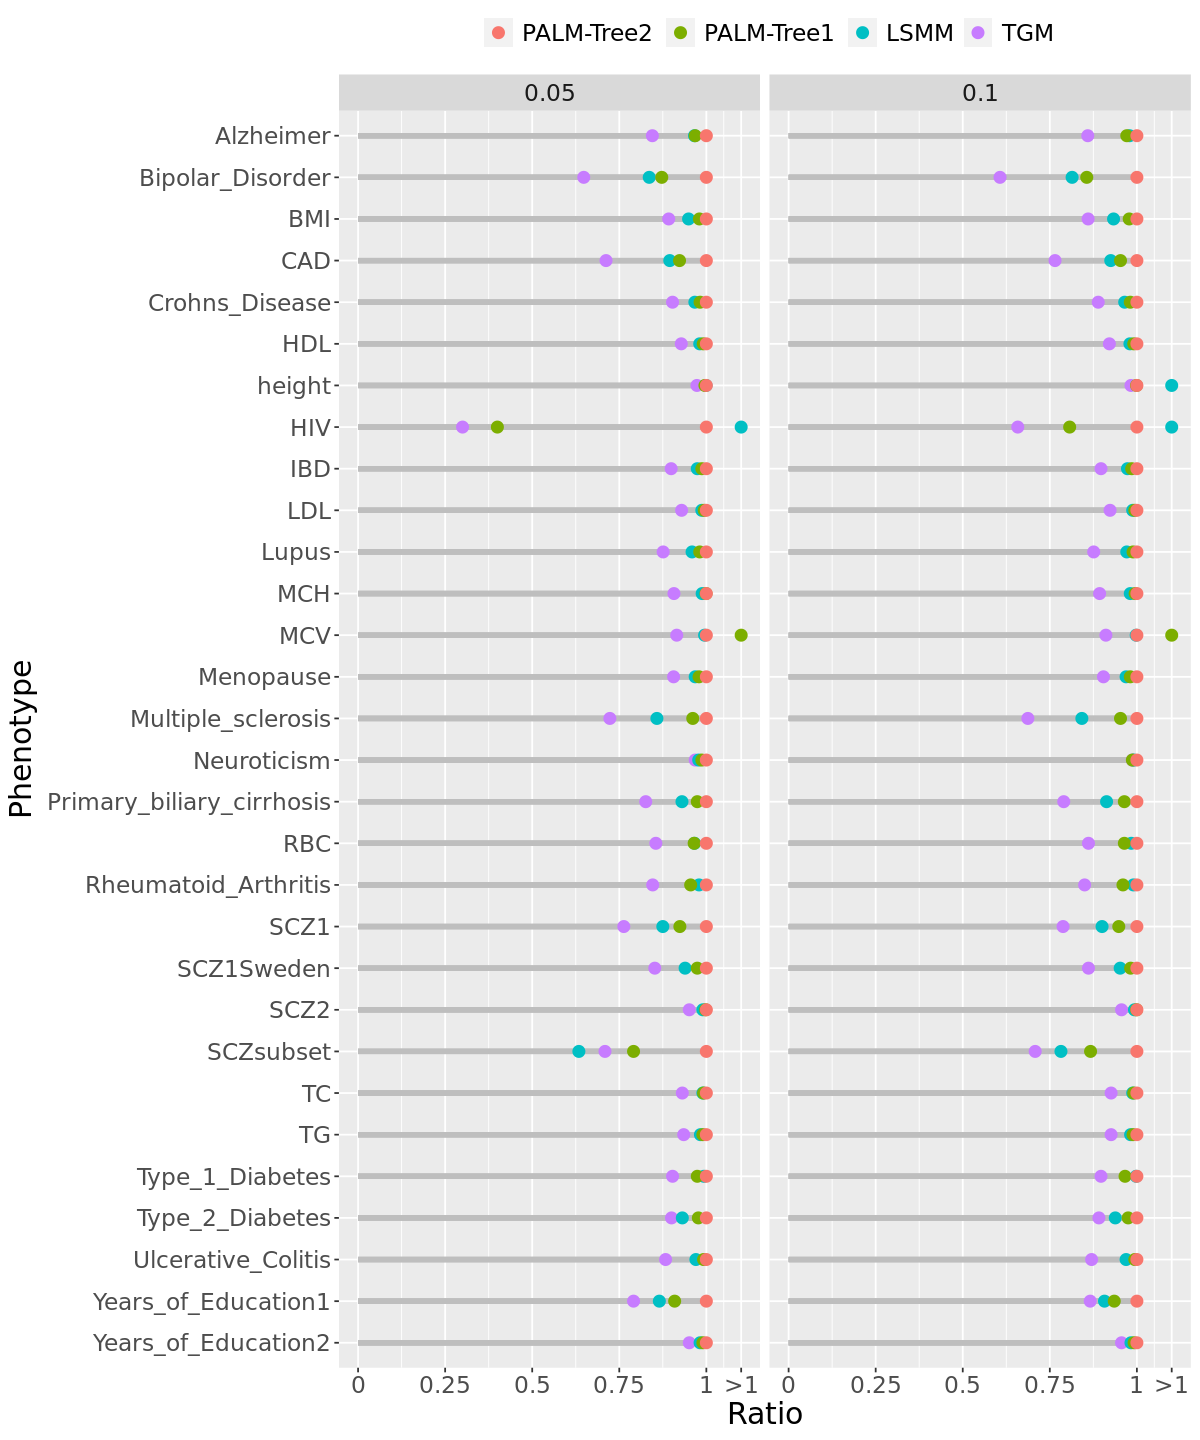

In [22]:
options(repr.plot.width=10, repr.plot.height=12)
g = ggplot(long, aes(color=Method)) +
  geom_segment(aes(x=0, y=Phenotype, xend=1, yend=Phenotype), size=1.5, color='gray') +
  geom_point(aes(x=Number, y=Phenotype), size=3) +
  facet_grid(cols=vars(facetlabel)) +
  xlab('Ratio') + ylab('Phenotype') +
  scale_x_continuous(breaks = c(0,0.25,0.5,0.75,1,1.1), labels = c('0','0.25','0.5','0.75','1','>1')) +
  scale_y_discrete(limits=rev) +
  guides(color=guide_legend(title="")) +
  theme(axis.text.x = element_text(size = 14),
        axis.text.y = element_text(size = 14),
        axis.title.x = element_text(size = 18),
        axis.title.y = element_text(size = 18),
        strip.text.x = element_text(size = 14),
        legend.text = element_text(size = 14),
        legend.position = 'top')
g

## Variable importance evaluation

In [8]:
anno = fread('../real/Roadmap_color.csv', sep=',')
imp_df = fread('../real/importance-gwas30-reg9tis127.csv', sep='\t')
imp_mat = as.matrix(imp_df[,-1])
rownames(imp_mat) = imp_df$V1

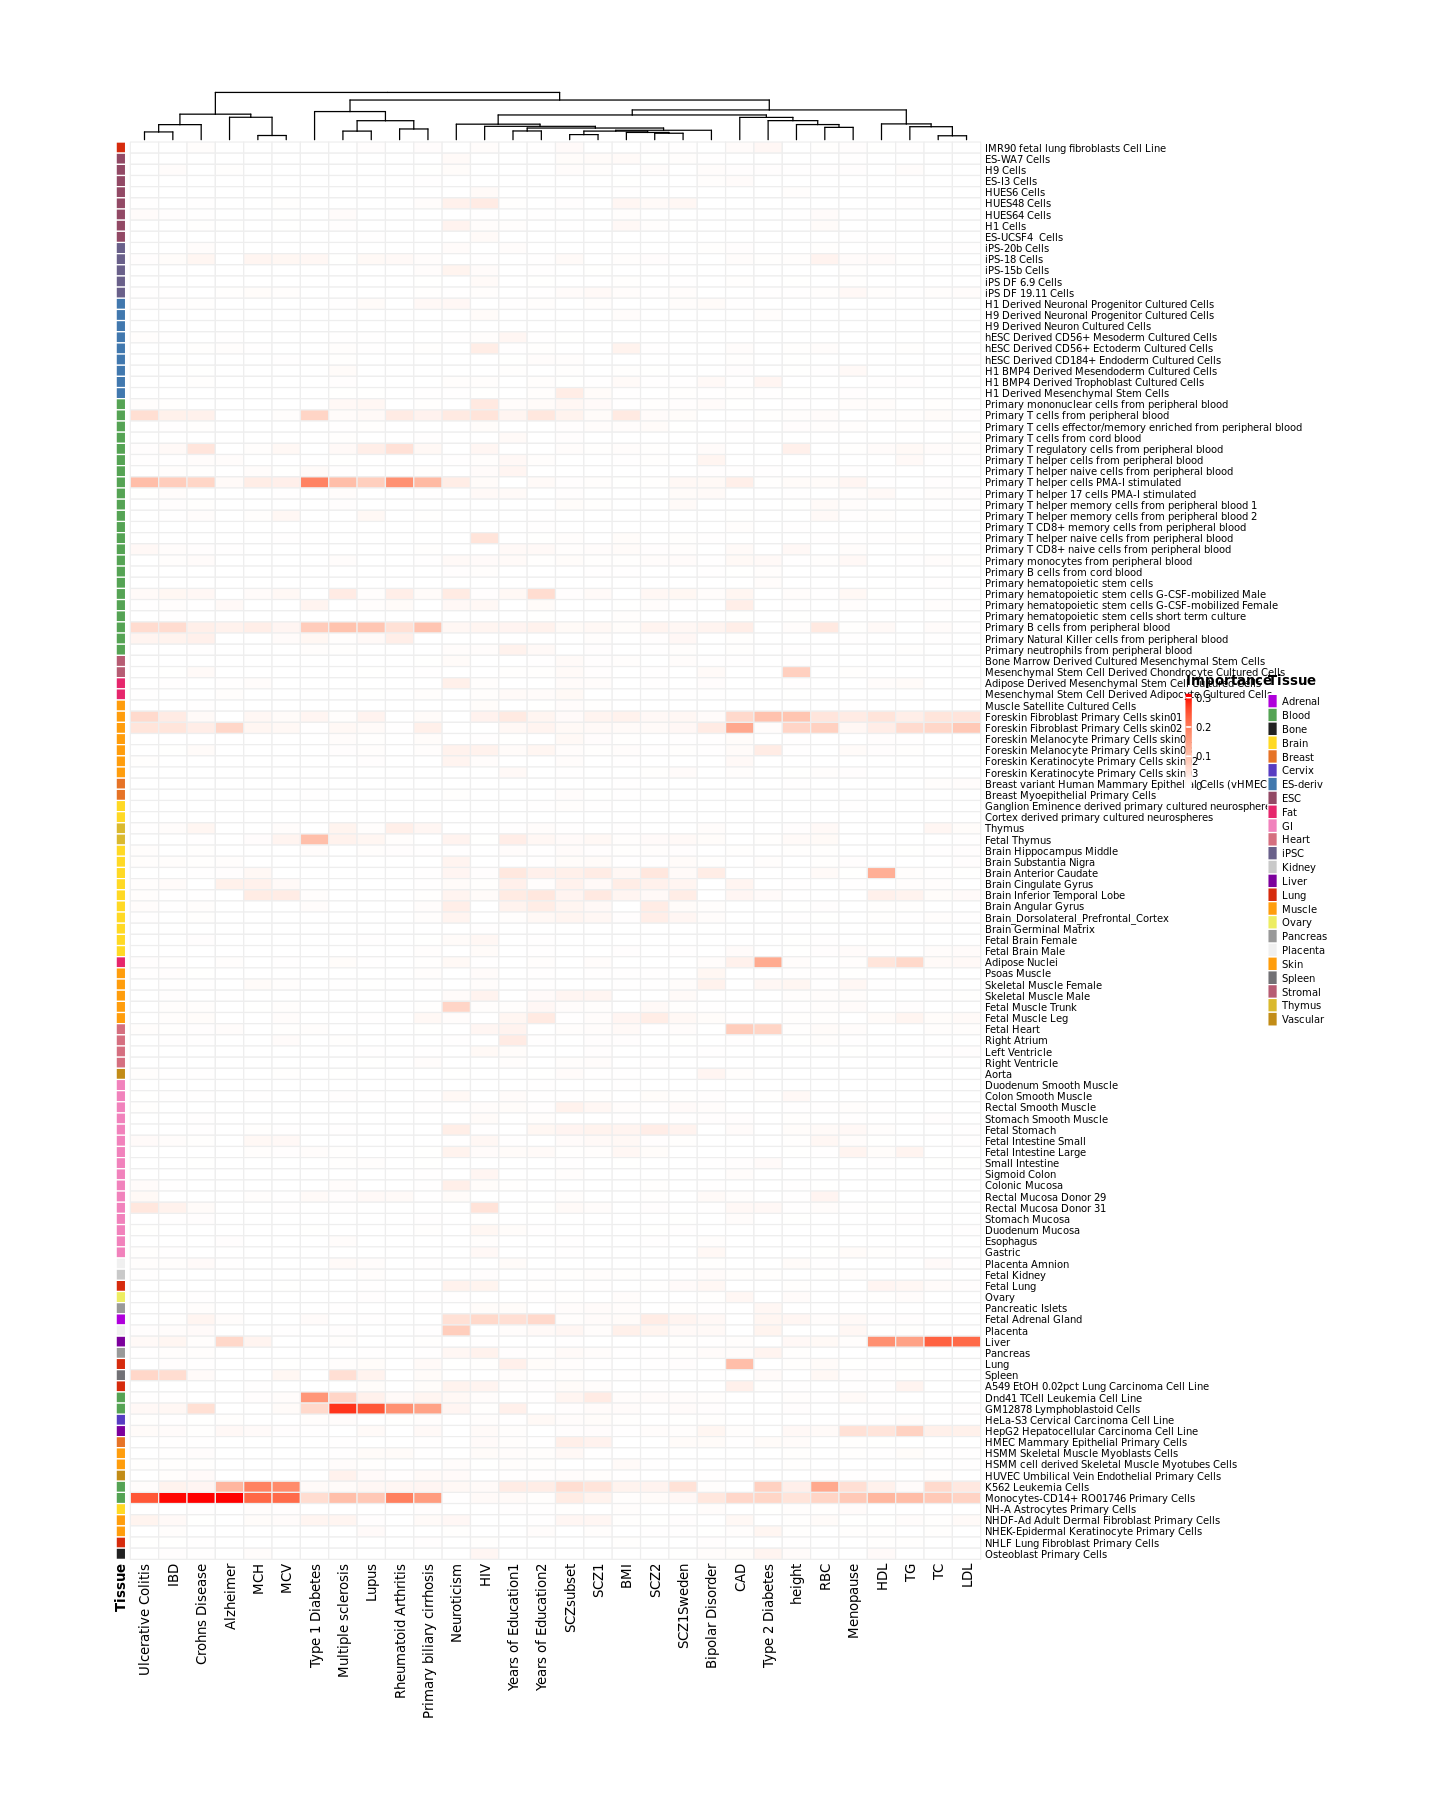

In [20]:
# color
col_ht = colorRamp2(c(0, 0.3), c('white', 'red'))
anatomy = sort(unique(anno$TISSUE))
col_anno = structure(toupper(anno$TISSUE_COLOR), names=anno$TISSUE)
col_map = col_anno[unique(names(col_anno))]
column_labels = structure(gsub('_', ' ', colnames(imp_df)), names=colnames(imp_df))
# left annotation
row_ha = rowAnnotation(Tissue=anno_simple(anno$TISSUE, col=col_anno, width=unit(2, 'mm'), gp=gpar(col='white')),
                       annotation_label = gt_render('Tissue', gp = gpar(fontsize=8, fontface='bold')))
# tissue legend
tis_lgd = Legend(labels=anatomy, title='Tissue',
                 legend_gp=gpar(fill=col_map[anatomy]),
                 grid_height = unit(1, "mm"), grid_width = unit(2, 'mm'),
                 labels_gp = gpar(fontsize=6),
                 title_gp = gpar(fontsize=8, fontface='bold'))

ht = Heatmap(imp_mat, border = F, column_gap = unit(1, "mm"),
             width=unit(18, 'cm'), height=unit(30, 'cm'), # ht size
             cluster_rows = F, column_title_gp = gpar(fontsize=8), # column
             #column_km=4, column_km_repeats = 1, # split
             col = col_ht, rect_gp = gpar(col='#EEEEEE', lwd=1), # ht color
             row_names_max_width = max_text_width(rownames(imp_mat), gp=gpar(fontsize=4)), # row name width
             row_names_gp = gpar(fontsize=6), column_names_gp = gpar(fontsize=8), # row/col name parameters
             column_labels = column_labels[colnames(imp_mat)], column_names_rot = 90, # col names
             left_annotation = row_ha, # tissue annotation
             heatmap_legend_param = list(title='Importance', legend_height=unit(2, 'cm'), 
                                         grid_width=unit(1, 'mm'), labels_gp=gpar(fontsize=6),
                                         title_gp = gpar(fontsize=8, fontface='bold')))
ht = draw(ht, annotation_legend_list=list(tis_lgd))